Notebook para avaliar modelo treinado com UA através da classificação do dataset com imagens sintéticas.

Modelo Classificador

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.fc1 = nn.Linear(16*5*5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16*5*5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Classificação com imagens reais

In [3]:
from data import create_dataset
from options.train_options import TrainOptions
import sys

Centralizado

Loaded 59997 examples
images dtype: uint8 shape: (59997, 28, 28)
labels dtype: int64 shape: (59997,)


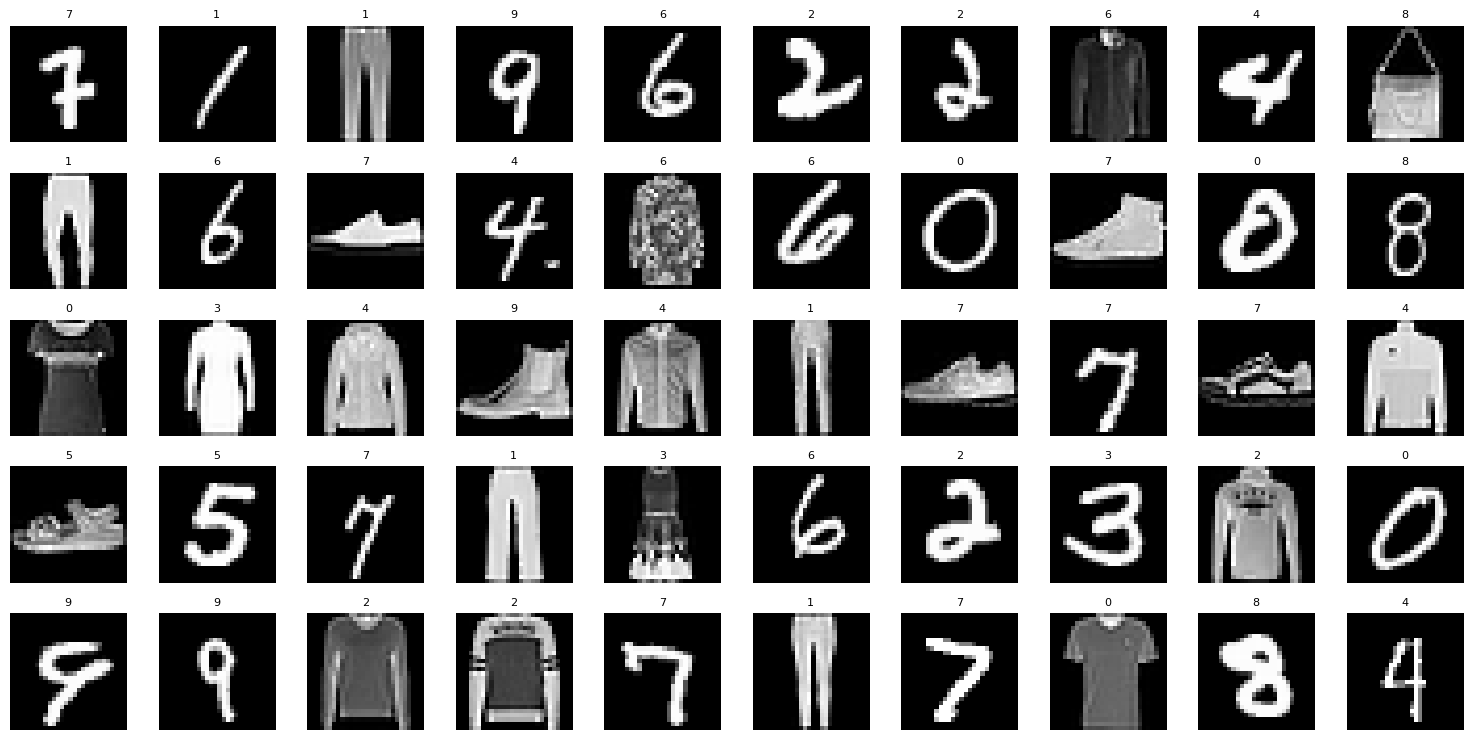

In [4]:
import h5py
import numpy as np
import matplotlib.pyplot as plt

with h5py.File('data/MNIST_fashionMNIST_imbalanced/train_MNIST_fashionMNIST.h5', 'r') as f:
    img_group = f['images']
    lbl_group = f['labels']
    keys = list(img_group.keys())
    n = len(keys)

    # Preallocate
    sample_img = img_group[keys[0]][()]
    H, W = sample_img.shape
    images = np.zeros((n, H, W), dtype=sample_img.dtype)
    labels = np.zeros((n,), dtype=int)

    for i, k in enumerate(keys):
        images[i] = img_group[k][()]
        labels[i] = lbl_group[k][()]

    # Shuffle
    perm = np.random.permutation(n)
    images = images[perm]
    labels = labels[perm]

    print("Loaded", n, "examples")
    print("images dtype:", images.dtype, "shape:", images.shape)
    print("labels dtype:", labels.dtype, "shape:", labels.shape)

    # Plot first 50 in a 5×10 grid
    num_to_show = 50
    rows, cols = 5, 10
    fig, axes = plt.subplots(rows, cols, figsize=(cols*1.5, rows*1.5))
    for idx in range(num_to_show):
        r, c = divmod(idx, cols)
        axes[r, c].imshow(images[idx], cmap='gray')
        axes[r, c].set_title(f"{labels[idx]}", fontsize=8)
        axes[r, c].axis('off')
    for idx in range(num_to_show, rows*cols):
        r, c = divmod(idx, cols)
        axes[r, c].axis('off')

    plt.tight_layout()
    plt.show()


In [24]:
args = [
    '--dataroot', './data/MNIST_fashionMNIST_imbalanced',
    '--name', 'mnistUniqueFashionUniform_UAGAN_10D',
    '--model', 'uagan',
    '--netG', 'cDCGANResnet',
    '--netD', 'cDCGANResnet',
    '--direction', 'AtoB',
    '--dataset_mode', 'mnist_fashionmnist',
    '--pool_size', '0',
    '--gpu_ids', '-1',
    '--niter', '200',
    '--niter_decay', '200',
    '--batch_size', '256',
    '--output_nc', '1',
    '--num_threads', '0',
    '--n_class', '10',
    '--ngf', '64',
    '--ndf', '64',
    '--nz', '128',
]

In [52]:
sys.argv = ['train.py'] + args
opt = TrainOptions().parse()
dataset = create_dataset(opt)

----------------- Options ---------------
               batch_size: 256                           	[default: 1]
                    beta1: 0.5                           
          checkpoints_dir: ./checkpoints                 
           continue_train: False                         
                crop_size: 32                            
                 dataroot: ./data                        	[default: None]
             dataset_mode: mnist_fashionmnist            	[default: unaligned]
                direction: AtoB                          
              display_env: main                          
             display_freq: 400                           
               display_id: 1                             
            display_ncols: 8                             
             display_port: 8097                          
           display_server: http://localhost              
          display_winsize: 64                            
                    epoch: latest     

dataset [MNISTFashionMNISTDataset] was created


In [42]:
net = Net().to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.01)

In [43]:
for epoch in range(100):
    net.train()
    running_loss = 0.0
    for i, data in enumerate(dataset):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data["B"].to(device), data["A"].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()

    print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / len(dataset):.3f}')

print('Finished Training')

[1,   235] loss: 0.002
[2,   235] loss: 0.001
[3,   235] loss: 0.001
[4,   235] loss: 0.001
[5,   235] loss: 0.001
[6,   235] loss: 0.001
[7,   235] loss: 0.001
[8,   235] loss: 0.001
[9,   235] loss: 0.001
[10,   235] loss: 0.001
[11,   235] loss: 0.001
[12,   235] loss: 0.001
[13,   235] loss: 0.001
[14,   235] loss: 0.001
[15,   235] loss: 0.001
[16,   235] loss: 0.001
[17,   235] loss: 0.001
[18,   235] loss: 0.001
[19,   235] loss: 0.001
[20,   235] loss: 0.001
[21,   235] loss: 0.001
[22,   235] loss: 0.001
[23,   235] loss: 0.001
[24,   235] loss: 0.001
[25,   235] loss: 0.001
[26,   235] loss: 0.000
[27,   235] loss: 0.000
[28,   235] loss: 0.001
[29,   235] loss: 0.001
[30,   235] loss: 0.000
[31,   235] loss: 0.000
[32,   235] loss: 0.001
[33,   235] loss: 0.000
[34,   235] loss: 0.000
[35,   235] loss: 0.000
[36,   235] loss: 0.000
[37,   235] loss: 0.000
[38,   235] loss: 0.000
[39,   235] loss: 0.000
[40,   235] loss: 0.000
[41,   235] loss: 0.000
[42,   235] loss: 0.000
[

In [44]:
torch.save(net.state_dict(), 'net_100e_mnistfmnistimb.pth')

In [18]:
args = [
    '--dataroot', './data',
    '--name', 'mnistUniqueFashionUniform_UAGAN_10D',
    '--model', 'uagan',
    '--netG', 'cDCGANResnet',
    '--netD', 'cDCGANResnet',
    '--direction', 'AtoB',
    '--dataset_mode', 'mnist_fashionmnist',
    '--gpu_ids', '-1',
    '--batch_size', '256',
    '--output_nc', '1',
    '--num_threads', '0',
    '--n_class', '10',
    '--ngf', '64',
    '--ndf', '64',
    '--nz', '128',
    '--serial_batches'
]

In [17]:
from options.test_options import TestOptions

In [62]:
import importlib
import data.mnist_fashionmnist_dataset
import data

importlib.reload(data.mnist_fashionmnist_dataset)
importlib.reload(data)

<module 'data' from '/Users/Mara/Documents/Mestrado/Pesquisa/UA/UAGAN/data/__init__.py'>

In [19]:
sys.argv = ['test.py'] + args
opt = TestOptions().parse()
opt.isTrain = False
testset = create_dataset(opt)

----------------- Options ---------------
             aspect_ratio: 1.0                           
               batch_size: 256                           	[default: 1]
          checkpoints_dir: ./checkpoints                 
                crop_size: 32                            
                 dataroot: ./data                        	[default: None]
             dataset_mode: mnist_fashionmnist            	[default: unaligned]
                direction: AtoB                          
          display_winsize: 64                            
                    epoch: latest                        
                     eval: False                         
                  gpu_ids: -1                            	[default: 0]
                init_gain: 0.02                          
                init_type: normal                        
                 input_nc: 3                             
                  isTrain: False                         	[default: None]
         

In [4]:
correct, loss = 0, 0.0
net.eval()
with torch.no_grad():
    for batch in testset:
        images = batch["B"].to(device)
        labels = batch["A"].to(device)
        outputs = net(images)
        loss += criterion(outputs, labels).item()
        correct += (torch.max(outputs.data, 1)[1] == labels).sum().item()
accuracy = correct / len(testset.dataset)
loss = loss / len(testset)

NameError: name 'net' is not defined

In [68]:
accuracy

0.9199

Dataset gerado por modelo treinado federado NIID ((fmnist iid e mnist uma classe por cliente))

UA GAN

In [24]:
from models import create_model
import models.networks as nets

In [5]:
class cDCGANGenerator(nn.Module):
    """Create a conditional DCGAN generator"""

    def __init__(self, input_nz, output_nc, ngf=64, norm_layer=nn.BatchNorm2d, num_classes=10):
        """Construct a Unet generator
        Parameters:
            input_nz (int)  -- the length of input noise vector
            output_nc (int) -- the number of channels in output images
            num_classes (int) -- the number of classes in the dataset
            ngf (int)       -- the number of filters in the last conv layer
            norm_layer      -- normalization layer

        """
        super(cDCGANGenerator, self).__init__()

        self.deconv1_1 = nn.ConvTranspose2d(input_nz, ngf * 2, kernel_size=4, stride=1, padding=0, bias=False)
        self.deconv1_1_bn = norm_layer(ngf * 2)
        # class one-hot vector input
        self.deconv1_2 = nn.ConvTranspose2d(num_classes, ngf * 2, kernel_size=4, stride=1, padding=0, bias=False)
        self.deconv1_2_bn = norm_layer(ngf * 2)
        self.deconv2 = nn.ConvTranspose2d(ngf * 4, ngf * 2, kernel_size=4, stride=2, padding=1, bias=False)
        self.deconv2_bn = norm_layer(ngf * 2)
        self.deconv3 = nn.ConvTranspose2d(ngf * 2, ngf, kernel_size=4, stride=2, padding=1, bias=False)
        self.deconv3_bn = norm_layer(ngf)
        self.deconv4 = nn.ConvTranspose2d(ngf, output_nc, kernel_size=4, stride=2, padding=1, bias=False)

    def forward(self, input, label):
        """Standard forward"""
        x = F.relu(self.deconv1_1_bn(self.deconv1_1(input)))
        y = F.relu(self.deconv1_2_bn(self.deconv1_2(label)))
        x = torch.cat([x, y], dim=1)
        x = F.relu(self.deconv2_bn(self.deconv2(x)))
        x = F.relu(self.deconv3_bn(self.deconv3(x)))
        x = torch.tanh(self.deconv4(x))
        return x
    

In [25]:
ua_gan = nets.cDCGANGenerator(input_nz=128, output_nc=1, ngf=32)
ua_gan.load_state_dict(torch.load("./checkpoints/mnistUniqueFashionUniform_UAGAN_10D/latest_net_G.pth"))

<All keys matched successfully>

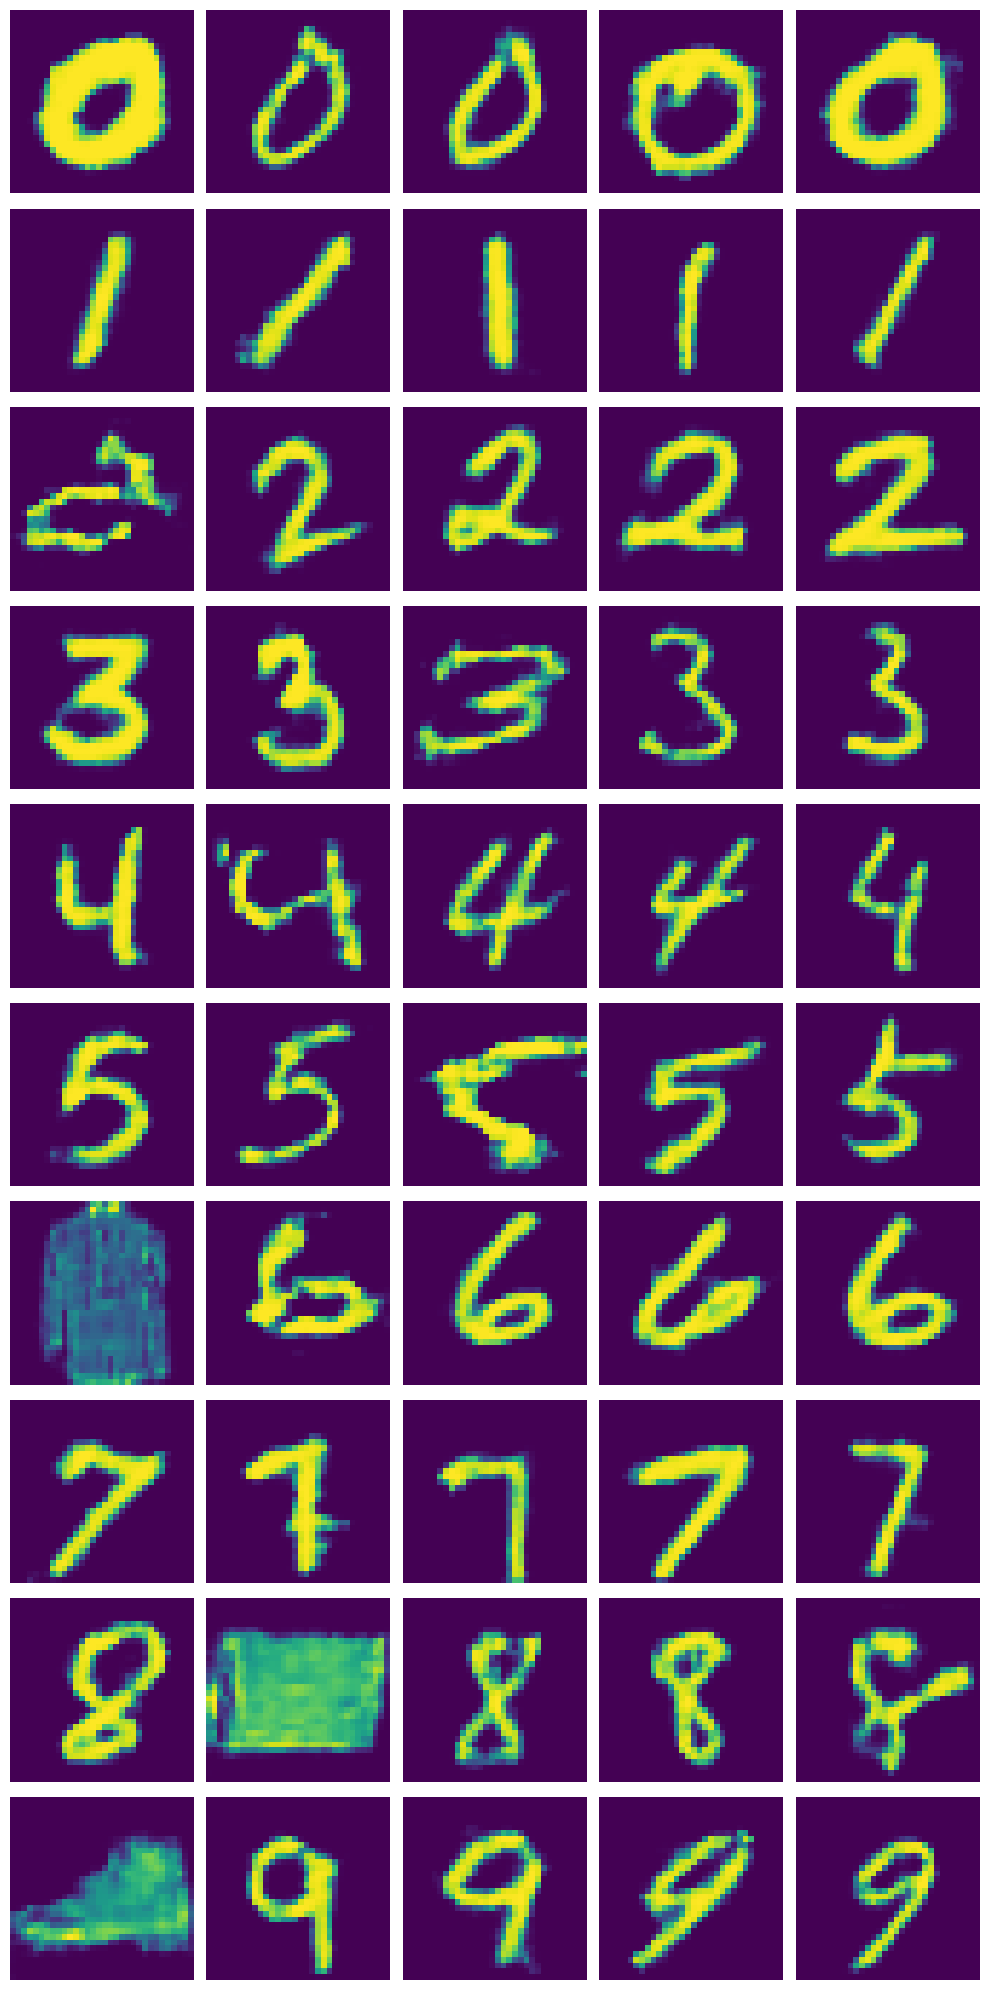

In [26]:
# parameters
n_classes  = 10
n_per_cls  = 5
latent_dim = 128

# 1) sample one batch of noise of size 10*5
batch_size = n_classes * n_per_cls
z = torch.randn(batch_size, latent_dim, 1, 1)

# 2) build labels: [0,0,0,0,0, 1,1,1,1,1, 2,2,...,9,9]
labels = torch.arange(n_classes).unsqueeze(1).repeat(1, n_per_cls).view(-1)

# 3) one-hot encode and reshape to (B,10,1,1)
labels_onehot = F.one_hot(labels, num_classes=n_classes).float().view(batch_size, n_classes, 1, 1)

# 4) generate images
ua_gan.eval()
with torch.no_grad():
    fake_images = ua_gan(z, labels_onehot)  # (50, C, H, W)

# 5) plot in a 10 x 5 grid
fake_np = fake_images.cpu().numpy()
fig, axes = plt.subplots(n_classes, n_per_cls, figsize=(n_per_cls*2, n_classes*2))

for cls in range(n_classes):
    for i in range(n_per_cls):
        idx = cls * n_per_cls + i
        img = fake_np[idx].transpose(1,2,0)  # (H,W,C)
        img = (img + 1) / 2                  # rescale from [-1,1] → [0,1]
        axes[cls, i].imshow(np.clip(img, 0, 1))
        axes[cls, i].axis('off')
        if i == 0:
            axes[cls, i].set_ylabel(f"Class {cls}", rotation=0, labelpad=40, va='center')

plt.tight_layout()
plt.show()

In [27]:
import torch
from torch.utils.data import Dataset
import torch.nn.functional as F
import random # Needed for handling remainders if samples aren't perfectly divisible

class GeneratedDataset(Dataset):
    def __init__(self,
                 generator,
                 num_samples,
                 latent_dim=100,
                 num_classes=10, # Total classes the generator model knows
                 desired_classes=None, # Optional: List of specific class indices to generate
                 device="cpu",
                 image_col_name="image",
                 label_col_name="label"):
        """
        Generates a dataset using a conditional generative model, potentially
        focusing on a subset of classes.

        Args:
            generator: The pre-trained generative model.
            num_samples (int): Total number of images to generate across the desired classes.
            latent_dim (int): Dimension of the latent space vector (z).
            num_classes (int): The total number of classes the generator was trained on.
                               This is crucial for correct label conditioning (e.g., one-hot dim).
            desired_classes (list[int], optional): A list of integer class indices to generate.
                                                  If None or empty, images for all classes
                                                  (from 0 to num_classes-1) will be generated,
                                                  distributed as evenly as possible.
                                                  Defaults to None.
            device (str): Device to run generation on ('cpu' or 'cuda').
            image_col_name (str): Name for the image column in the output dictionary.
            label_col_name (str): Name for the label column in the output dictionary.
        """
        self.generator = generator
        self.num_samples = num_samples
        self.latent_dim = latent_dim
        # Store the total number of classes the generator understands
        self.total_num_classes = num_classes
        self.device = device
        self.model_type = type(self.generator).__name__ # Get generator class name
        self.image_col_name = image_col_name
        self.label_col_name = label_col_name

        # Determine the actual classes to generate based on desired_classes
        if desired_classes is not None and len(desired_classes) > 0:
            # Validate that desired classes are within the generator's known range
            if not all(0 <= c < self.total_num_classes for c in desired_classes):
                raise ValueError(f"All desired classes must be integers between 0 and {self.total_num_classes - 1}")
            # Use only the unique desired classes, sorted for consistency
            self._actual_classes_to_generate = sorted(list(set(desired_classes)))
        else:
            # If no specific classes desired, generate all classes
            self._actual_classes_to_generate = list(range(self.total_num_classes))

        # The 'classes' attribute of the dataset reflects only those generated
        self.classes = self._actual_classes_to_generate
        self.num_generated_classes = len(self.classes) # Number of classes being generated

        if self.num_generated_classes == 0 and self.num_samples > 0:
             raise ValueError("Cannot generate samples with an empty list of desired classes.")
        elif self.num_samples == 0:
             print("Warning: num_samples is 0. Dataset will be empty.")
             self.images = torch.empty(0) # Adjust shape if known
             self.labels = torch.empty(0, dtype=torch.long)
        else:
             # Generate the data only if needed
             self.images, self.labels = self.generate_data()


    def generate_data(self):
        """Generates images and corresponding labels for the specified classes."""
        self.generator.eval()
        self.generator.to(self.device)

        # --- Create Labels ---
        generated_labels_list = []
        if self.num_generated_classes > 0:
            # Distribute samples as evenly as possible among the desired classes
            samples_per_class = self.num_samples // self.num_generated_classes
            for cls in self._actual_classes_to_generate:
                generated_labels_list.extend([cls] * samples_per_class)

            # Handle remaining samples if num_samples is not perfectly divisible
            num_remaining = self.num_samples - len(generated_labels_list)
            if num_remaining > 0:
                # Add remaining samples by randomly choosing from the desired classes
                remainder_labels = random.choices(self._actual_classes_to_generate, k=num_remaining)
                generated_labels_list.extend(remainder_labels)

            # Shuffle labels for better distribution in batches later
            random.shuffle(generated_labels_list)

        # Convert labels list to tensor
        labels = torch.tensor(generated_labels_list, dtype=torch.long, device=self.device)

        # Double check label count (should match num_samples due to logic above)
        if len(labels) != self.num_samples:
             # This indicates an unexpected issue, potentially if num_generated_classes was 0 initially
             # but num_samples > 0. Raise error or adjust. Let's adjust defensively.
             print(f"Warning: Label count mismatch. Expected {self.num_samples}, got {len(labels)}. Adjusting size.")
             if len(labels) > self.num_samples:
                 labels = labels[:self.num_samples]
             else:
                 # Pad if too few (less likely with current logic unless num_generated_classes=0)
                 num_needed = self.num_samples - len(labels)
                 if self.num_generated_classes > 0:
                      padding = torch.tensor(random.choices(self._actual_classes_to_generate, k=num_needed), dtype=torch.long, device=self.device)
                      labels = torch.cat((labels, padding))
                 # If no classes to generate from, labels tensor might remain smaller

        # --- Create Latent Noise ---
        z = torch.randn(self.num_samples, self.latent_dim, device=self.device)

        # --- Generate Images in Batches ---
        generated_images_list = []
        # Consider making batch_size configurable
        batch_size = min(1024, self.num_samples) if self.num_samples > 0 else 1

        with torch.no_grad():
            for i in range(0, self.num_samples, batch_size):
                z_batch = z[i : min(i + batch_size, self.num_samples)]
                labels_batch = labels[i : min(i + batch_size, self.num_samples)]

                # Skip if batch is empty (can happen if num_samples = 0)
                if z_batch.shape[0] == 0:
                    continue

                # --- Condition the generator based on its type ---
                if self.model_type == 'Generator': # Assumes input: concat(z, one_hot_label)
                    # One-hot encode labels using the TOTAL number of classes the generator knows
                    labels_one_hot_batch = F.one_hot(labels_batch, num_classes=self.total_num_classes).float()
                    generator_input = torch.cat([z_batch, labels_one_hot_batch], dim=1)
                    gen_imgs = self.generator(generator_input)
                elif self.model_type == 'CGAN' or self.model_type == "F2U_GAN": # Assumes input: z, label_index
                    gen_imgs = self.generator(z_batch, labels_batch)
                elif self.model_type == "cDCGANGenerator":
                    z_in = z_batch.unsqueeze(2).unsqueeze(3)
                    labels_oh = F.one_hot(labels_batch, num_classes=self.total_num_classes).float().to(self.device)
                    labels_in = labels_oh.unsqueeze(2).unsqueeze(3)
                    gen_imgs = self.generator(z_in, labels_in)
                else:
                    # Handle other potential generator architectures or raise an error
                    raise NotImplementedError(f"Generation logic not defined for model type: {self.model_type}")

                generated_images_list.append(gen_imgs.cpu()) # Move generated images to CPU

        self.generator.cpu() # Move generator back to CPU after generation

        # Concatenate all generated image batches
        if generated_images_list:
            all_gen_imgs = torch.cat(generated_images_list, dim=0)
        else:
            # If no images were generated (e.g., num_samples = 0)
            # Create an empty tensor. Shape needs care - determine from generator or use placeholder.
            # Let's attempt a placeholder [0, C, H, W] - requires knowing C, H, W.
            # For now, a simple empty tensor. User might need to handle this downstream.
            print("Warning: No images generated. Returning empty tensor for images.")
            all_gen_imgs = torch.empty(0)

        return all_gen_imgs, labels.cpu() # Return images and labels (on CPU)

    def __len__(self):
        # Return the actual number of samples generated
        return self.images.shape[0]

    def __getitem__(self, idx):
        if idx >= len(self):
            raise IndexError("Dataset index out of range")
        return {
            self.image_col_name: self.images[idx],
            self.label_col_name: int(self.labels[idx]) # Return label as standard Python int
        }


In [28]:
from torch.utils.data import DataLoader

In [29]:
# Parameters
num_samples = 60000
latent_dim = 128

# Create the dataset and dataloader
generated_dataset = GeneratedDataset(generator=ua_gan, num_samples=num_samples, latent_dim=latent_dim, num_classes=10, device="cpu")
generated_dataloader = DataLoader(generated_dataset, batch_size=64, shuffle=True)

In [30]:
net = Net().to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.01)

In [31]:
for epoch in range(100):
    net.train()
    running_loss = 0.0
    for i, data in enumerate(generated_dataloader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data["image"].to(device), data["label"].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()

    print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / len(generated_dataset):.3f}')

print('Finished Training')

[1,   938] loss: 0.004
[2,   938] loss: 0.002
[3,   938] loss: 0.002
[4,   938] loss: 0.002
[5,   938] loss: 0.002
[6,   938] loss: 0.002
[7,   938] loss: 0.002
[8,   938] loss: 0.002
[9,   938] loss: 0.002
[10,   938] loss: 0.002
[11,   938] loss: 0.002
[12,   938] loss: 0.002
[13,   938] loss: 0.002
[14,   938] loss: 0.002
[15,   938] loss: 0.003
[16,   938] loss: 0.002
[17,   938] loss: 0.002
[18,   938] loss: 0.002
[19,   938] loss: 0.002
[20,   938] loss: 0.002
[21,   938] loss: 0.003
[22,   938] loss: 0.002
[23,   938] loss: 0.002
[24,   938] loss: 0.004
[25,   938] loss: 0.004
[26,   938] loss: 0.004
[27,   938] loss: 0.003
[28,   938] loss: 0.005
[29,   938] loss: 0.005
[30,   938] loss: 0.004
[31,   938] loss: 0.004
[32,   938] loss: 0.005
[33,   938] loss: 0.004
[34,   938] loss: 0.005
[35,   938] loss: 0.006
[36,   938] loss: 0.006
[37,   938] loss: 0.006
[38,   938] loss: 0.006
[39,   938] loss: 0.008
[40,   938] loss: 0.007
[41,   938] loss: 0.007
[42,   938] loss: 0.006
[

In [32]:
correct, loss = 0, 0.0
net.eval()
with torch.no_grad():
    for batch in testset:
        images = batch["B"].to(device)
        labels = batch["A"].to(device)
        outputs = net(images)
        loss += criterion(outputs, labels).item()
        correct += (torch.max(outputs.data, 1)[1] == labels).sum().item()
accuracy = correct / len(testset.dataset)
loss = loss / len(testset)

In [33]:
accuracy

0.099

Federado NIID (fmnist iid e mnist uma classe por cliente)

In [4]:
args = [
    '--dataroot', './data/MNIST_fashionMNIST_imbalanced',
    '--name', 'mnistUniqueFashionUniform_UAGAN_10D',
    '--model', 'uagan',
    '--netG', 'cDCGANResnet',
    '--netD', 'cDCGANResnet',
    '--direction', 'AtoB',
    '--dataset_mode', 'mnist_fashionmnist_split',
    '--pool_size', '0',
    '--gpu_ids', '-1',
    '--niter', '200',
    '--niter_decay', '200',
    '--batch_size', '256',
    '--output_nc', '1',
    '--num_threads', '0',
    '--n_class', '10',
    '--ngf', '64',
    '--ndf', '64',
    '--nz', '128',
]

In [7]:
sys.argv = ['train.py'] + args

In [8]:
opt = TrainOptions().parse()

----------------- Options ---------------
               batch_size: 256                           	[default: 1]
                    beta1: 0.5                           
          checkpoints_dir: ./checkpoints                 
           continue_train: False                         
                crop_size: 32                            
                 dataroot: ./data/MNIST_fashionMNIST_imbalanced	[default: None]
             dataset_mode: mnist_fashionmnist_split      	[default: unaligned]
                direction: AtoB                          
              display_env: main                          
             display_freq: 400                           
               display_id: 1                             
            display_ncols: 8                             
             display_port: 8097                          
           display_server: http://localhost              
          display_winsize: 64                            
                    epoch: lates

In [9]:
dataset = create_dataset(opt)

Load: train_MNIST_unique_fashionMNIST_uniform_0.h5
Load: train_MNIST_unique_fashionMNIST_uniform_1.h5
Load: train_MNIST_unique_fashionMNIST_uniform_2.h5
Load: train_MNIST_unique_fashionMNIST_uniform_3.h5
Load: train_MNIST_unique_fashionMNIST_uniform_4.h5
Load: train_MNIST_unique_fashionMNIST_uniform_5.h5
Load: train_MNIST_unique_fashionMNIST_uniform_6.h5
Load: train_MNIST_unique_fashionMNIST_uniform_7.h5
Load: train_MNIST_unique_fashionMNIST_uniform_8.h5
Load: train_MNIST_unique_fashionMNIST_uniform_9.h5
dataset [MNISTFashionMNISTSplitDataset] was created
